#labels
backward
bed
bird
cat
dog
down
eight
five
follow
forward
four
go
happy
house
learn
left
marvin
nine
no
off
on
one
right
seven
sheila
six
stop
three
tree
two
up
visual
wow
yes
zero

## load model and prameters

In [61]:
from __future__ import print_function
import argparse
import pickle

import numpy as np
import torch
from torch import Tensor
import torch.optim as optim
from gcommand_loader import GCommandLoader
from train import train, test
#from attacks import attack

import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
class args():

    def _init_(self, name):
        pass
    def cuda(self,x):
        pass         
    def train_path(self,x):
        pass
    def test_path(self,x):
        pass
    def test_batch_size(self,x):
        pass
    def arc(self,x):
        pass
    def epochs(self,x):
        pass
    def lr(self,x):
        pass
    def momentum(self,x):
        pass
    def optimizer(self,x):
        pass    
    def log_interval(self,x):
        pass
    def seed(self,x):
        pass
    def patience(self,x):
        pass
    def window_size(self,x):
        pass
    def window_stride(self,x):
        pass
    def window_type(self,x):
        pass    
    def normalize(self,x):
        pass
    def chkpt_path(self,x):
        pass
    def chkpt_path_train(self,x):
        pass
    def n_iter(self,x):
        pass
    def eps(self,x):
        pass    
    def alpha(self,x):
        pass
    def test_mode(self,x):
        pass
args.train_path='../data/gcommands/train'#
args.test_path='../data/gcommands/test'
args.valid_path='../data/gcommands/valid'
#args.train_path='/home/maayanl//data/data2/valid'#/media/maayanl/HD-27/LPC/data/data2/
#args.test_path='/home/maayanl//data/data2/test'
#args.valid_path='/home/maayanl//data/data2/valid'
args.batch_size=128
args.test_batch_size=64
args.arc='VGG11'#'network architecture:  VGG16, VGG11, VGG13, VGG16, VGG19'
args.epochs=100#TODO:default=100

args.lr=0.001
args.momentum=0.9#help='SGD momentum, for SGD only'
args.optimizer='adam'#' help=optimization method: sgd | adam'
args.cuda=True
args.log_interval=50
args.cuda = args.cuda and torch.cuda.is_available()
args.seed="1434"
args.patience=5
args.window_size=0.02
args.window_stride=0.01
args.window_type='hamming'
args.normalize=True

args.test_mode=False #parser.add_argument('--test_mode', action="store_true", help='Whether to run model for test only or not')
args.chkpt_path="chkpt_pathD"
args.chkpt_path_train="chkpt_path_trainD"

args.n_iter=20
args.eps=0.02
args.alpha=0.01
import torch.nn as nn
import torch.nn.functional as F
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
        self.conv2 = nn.Conv2d(20, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(17468, 1000)
        self.fc2 = nn.Linear(1000, 2)#TODO:WAS 35 run1

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
def _make_layers(cfg):
    layers = []
    in_channels = 1
    for x in cfg:
        if x == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                       nn.BatchNorm2d(x),
                       nn.ReLU(inplace=True)]
            in_channels = x
    layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
    return nn.Sequential(*layers)


cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = _make_layers(cfg[vgg_name])
        self.fc1 = nn.Linear(7680, 512)
        self.fc2 = nn.Linear(512, 35)#TODO:WAS 35 run1

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return F.log_softmax(out,dim=1)
# load model

checkpoint=torch.load('./checkpoint/chkpt_path_trainD.t7')
model=checkpoint['net']
model=model.eval()
# define optimizer
if args.optimizer.lower() == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
elif args.optimizer.lower() == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=args.lr,
                          momentum=args.momentum)
else:
    optimizer = optim.SGD(model.parameters(), lr=args.lr,
                          momentum=args.momentum)
valid_loss=checkpoint['acc']
epoch=checkpoint['epoch']
optimizer.state_dict=checkpoint['optimizer_state_dict:']
test_dataset = GCommandLoader(args.test_path, window_size=args.window_size, window_stride=args.window_stride,
                            window_type=args.window_type, normalize=args.normalize)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=args.test_batch_size, shuffle=False,
    num_workers=8, pin_memory=args.cuda, sampler=None)

In [62]:
print(torch.cuda.device_count())

1


#### see the cuda total_memory and empty_cache

In [63]:
t = torch.cuda.get_device_properties(0).total_memory
print('total_memory',t/1e9)
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
print('memory_allocated',a/1e9)
#torch.cuda.empty_cache()
print('memory_reserved',r/1e9)

total_memory 11.546525696
memory_allocated 0.1641344
memory_reserved 2.617245696


In [64]:
import torchaudio
import librosa
import torchattacks
import IPython.display as ipd
import torchaudio
from matplotlib import pyplot as plt 

# pgd attack baced on spectogram
## inva for etch batch 
## inva_attack for all the data

In [131]:
import torch
import torch.nn as nn
from torchattacks import attack
import PGDO
def inva(dataloader, spect, y,model, n_iter=10, eps=0.01, alpha=0.01/2, rand_init=True):
    """Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)
        alpha (float): step size. (Default: 2/255)
        steps (int): number of steps. (Default: 10)
        random_start (bool): using random initialization of delta. (Default: True)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = n_iternumber of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`."""
    atk = PGDO.PGD_no_clip(model, eps, alpha, steps=n_iter)#TODO:OR USE PGD_no_clip OR NORMLIZE SPEC FROM MIN 0 TO MAX 1 AND THAN REVERSE
    adv_images = atk(spect, y)
    return adv_images
def inva_attack(dataloader, example_id, model, n_iter=10, eps=0.01, alpha=0.01/2, rand_init=True):
    total=0
    cr=0
    example_id=-1
    for (data, y) in dataloader:#.dataset.spects
        example_id+=1
        #print("example_id",example_id)
        #x, y = dataloader.dataset.spects[example_idx]
        total += y.size(0)

        adv_images=inva(test_loader,data,y, model, n_iter,eps=eps, alpha =alpha, rand_init=True)
        yhat_adv = model(adv_images)
        #print(f"real label {y},adj label {yhat_adv.argmax()}")
        cor=torch.eq(yhat_adv.argmax(dim=1).cpu(), y)
        correct=sum(cor==False)
        cr+=correct

    print(f"PGD accuracy {cr*100/total} ({cr}/{total})")
    return adv_images,cr*100/total
#audio,_=inva_attack(test_loader,0, model, n_iter=10,eps=args.eps*3, alpha =args.alpha, rand_init=True)

# show the succses of the pgd attack

In [132]:
eps_s =np.linspace(0.02, 0.09, num=1)
#eps_s =[0,0.001    ,  0.031625  , 0.18 ,0.25]
eps_s=[]
#eps_s=[]#delete eps_s
prc=[]   
for eps in eps_s:
    print(" for eps  ",eps)
    audio,pr=inva_attack(test_loader,0, model, n_iter=args.n_iter,eps=args.eps, alpha =args.alpha, rand_init=True)
    prc.append(pr.item()/100)


<function matplotlib.pyplot.show(close=None, block=None)>

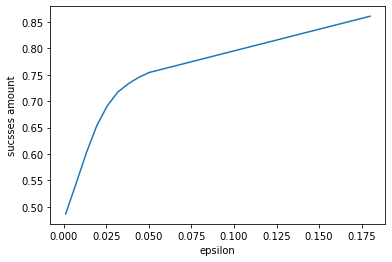

In [133]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.image as img
y=[0.4867369079589844, 0.5442405700683594, 0.6030159759521484, 0.6543422698974609, 0.69140625, 0.7172056579589844, 0.7329215240478516, 0.7449127960205079, 0.7542696380615235, 0.8608284759521484]
x=[0.001   , 0.007125, 0.01325,  0.019375 ,0.0255 ,  0.031625 ,0.03775 , 0.043875, 0.05 , 0.18 ]
plt.plot(x,y)
#plt.plot(args.eps,prc,'+')

print
plt.xlabel("epsilon")
plt.ylabel("sucsses amount")
#im = img.imread('sucsses0.1_5_num_918.png')
#plt.imshow(im)
plt.show
#plt.savefig('../output/epsilon_.png')

## get one  inverse spect_anv and one inverse spect

real label 0,adj label 31
[1, 1, 161, 101]


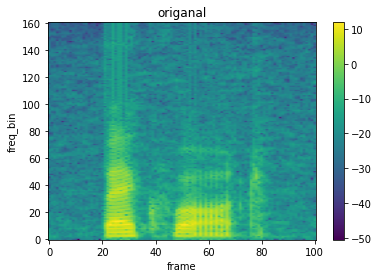

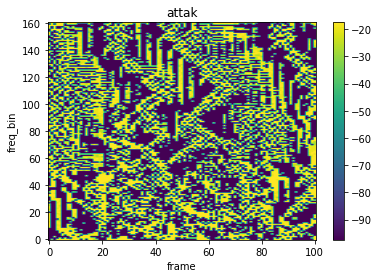

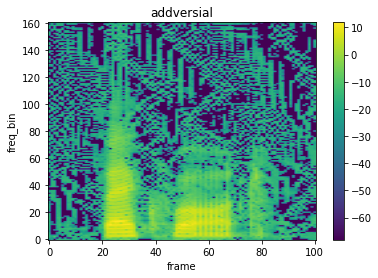

tensor(0.4331)


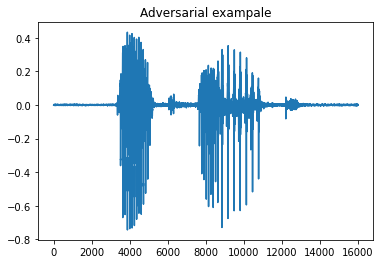

In [142]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)
def make_plot_spectrogram(dataloader,example_idx, title=None, ylabel="freq_bin"):
    x, y = dataloader.dataset.spects[example_idx]
    y=torch.tensor(y).unsqueeze(0)            
    audio, sr = torchaudio.load(x)
    specgram, _ = dataloader.dataset.stft.transform(audio)
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram[0]), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)
def inv1(dataloader, example_idx, model, n_iter=10, eps=0.01, alpha=0.01/2, rand_init=True):

    x, y = dataloader.dataset.spects[example_idx]
    y=torch.tensor(y).unsqueeze(0)            
    audio, sr = torchaudio.load(x)
    spect, phase = dataloader.dataset.stft.transform(audio)
    spect = spect.unsqueeze(0)


    spect_attack=inva(dataloader,spect,y.cpu(), model, n_iter,eps=eps, alpha =alpha, rand_init=True)
    with torch.no_grad():
        y_hat=model(spect.cuda())
        yhat_adv = model(spect_attack)
        print(f"real label {y_hat.argmax()},adj label {model(spect_attack).argmax()}")
        print(list(spect_attack.shape))
        plot_spectrogram(spect[0,0].cpu(),"origanal")
        plot_spectrogram((spect_attack[0,0].cpu()-spect[0,0].cpu()),"attak")
        plot_spectrogram(spect_attack[0,0].cpu(),"addversial")

        output = dataloader.dataset.stft.inverse(spect_attack[0].cpu(), phase.cpu())

        output_inverse = dataloader.dataset.stft.inverse(spect[0].cpu(), phase.cpu())
        output=output/torch.mean(output[0])*torch.mean(output_inverse[0])
        print(max(output[0]))
        #audio_c = audio.cpu().data.numpy()
        #ipd.Audio(audio_c, rate=16000)
        return output,output_inverse
index=120
audio_adv,audio_inverse=inv1(test_loader,index, model, n_iter=4*args.n_iter,eps=0.018, alpha =0.8*args.alpha, rand_init=True)

plt.plot(audio_adv.t().numpy());
plt.title('Adversarial exampale')
ipd.Audio(audio_adv , rate=16000)


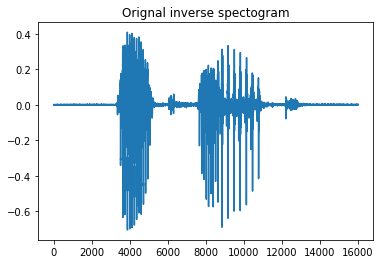

In [111]:
plt.plot(audio_inverse.t().numpy());
plt.title('Orignal inverse spectogram')

ipd.Audio(audio_inverse , rate=16000)

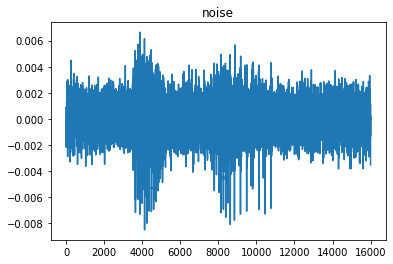

In [112]:
plt.plot((-audio_inverse+audio_adv).t().numpy())
plt.title('noise')
ipd.Audio((audio_adv-audio_inverse ), rate=16000)


[1, 100, 20]


/tmp/ipykernel_15343/4084453881.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alphas_adv    = lpc_prep( torch.tensor(audio_adv) )


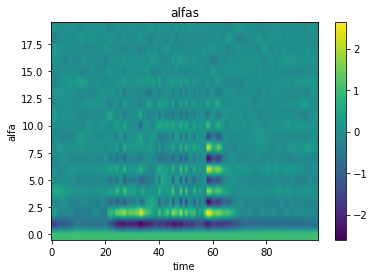

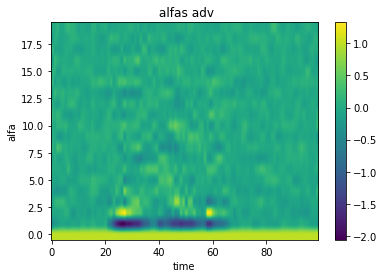

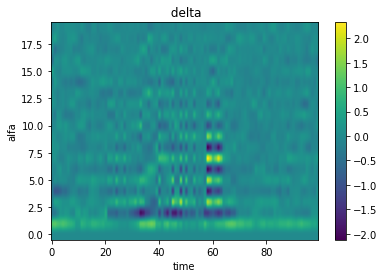

mean_squared_error 0.11466231
tensor(0.1817)
tensor(0.3097)


In [153]:
x, y = test_loader.dataset.spects[index]
sr = 16000
audio=audio_inverse

# Parameters
#     * sr            : sample rate of the signal ( 16 kHz )
#     * frame_duration: duration of the window in seconds ( 16 ms )
#     * frame_overlap : frame overlapping factor
#     * K             : number of linear predictive coding coefficients
sr             = 16000
#frame_duration = .016
#frame_overlap  = .5
K              = 20
frame_duration = args.window_size

frame_overlap  = args.window_stride/args.window_size-0.0001

# Initialize the module given all the parameters
from lpctorch import LPCCoefficients
lpc_prep       = LPCCoefficients(
    sr,
    frame_duration,
    frame_overlap,
    order = ( K - 1 ),
    window=torch.hamming_window,
    padded=True
)


def plot_alfas(alphas, title=None, ylabel="alfa"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "alfas")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("time")
    im = axs.imshow(alphas.T, origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

# Get the coefficients given a signal
# torch.Tensor of size ( Batch, Samples )
alphas         = lpc_prep( audio )
alphas_adv    = lpc_prep( torch.tensor(audio_adv) )
print(list(alphas.shape))


plot_alfas(alphas[0])
plot_alfas(alphas_adv[0],title=" alfas adv")
plot_alfas(alphas_adv[0]-alphas[0],title=" delta")

from sklearn.metrics import mean_squared_error
print( "mean_squared_error",mean_squared_error(abs(alphas_adv[0]),abs(alphas[0])))
mean = Tensor.mean(abs(alphas_adv))
print(mean)
mean = Tensor.mean(abs(alphas))
print(mean)

real label 0,adj label 16
[1, 1, 161, 101]


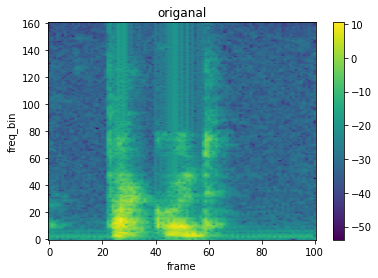

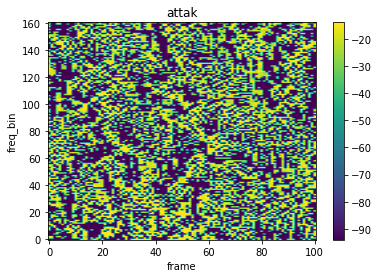

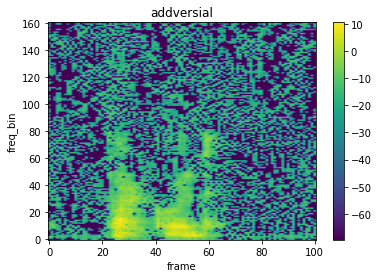

tensor(0.3092)


/app/dockvenv/lib/python3.8/site-packages/torch_stft/util.py:40: FutureWarning: Pass size=320 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  win_sq = librosa_util.pad_center(win_sq, n_fft)
/tmp/ipykernel_15343/2770327404.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alphas_adv    = lpc_prep( torch.tensor(audio_adv) )


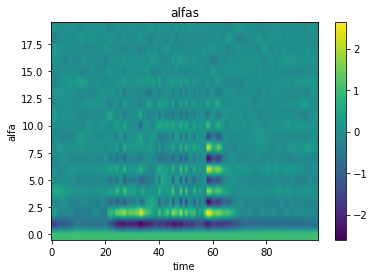

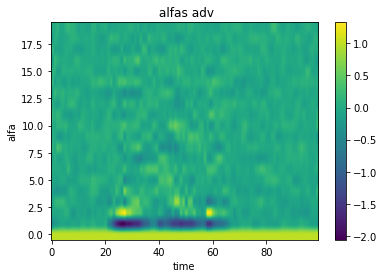

mean_squared_error 0.11466231
tensor(0.1817)
tensor(0.3097)


In [149]:
index=41
audio_adv,audio_inverse=inv1(test_loader,index, model, n_iter=4,eps=0.04, alpha =args.alpha, rand_init=True)
alphas         = lpc_prep( audio_inverse )
alphas_adv    = lpc_prep( torch.tensor(audio_adv) )
plot_alfas(alphas[0])
plot_alfas(alphas_adv[0],title=" alfas adv")
# Get the coefficients given a signal
# torch.Tensor of size ( Batch, Samples )

from sklearn.metrics import mean_squared_error
print( "mean_squared_error",mean_squared_error(abs(alphas_adv[0]),abs(alphas[0])))
mean = Tensor.mean(abs(alphas_adv))
print(mean)
mean = Tensor.mean(abs(alphas))

print(mean)
ipd.Audio(audio_adv , rate=16000)


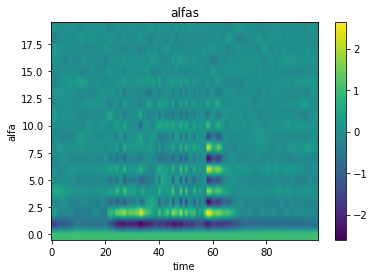

In [151]:
x, y = test_loader.dataset.spects[index]
sr = 16000
audio=torchaudio.load(x,16000)
alphas1 = lpc_prep( audio_inverse )

plot_alfas(alphas1[0])


import torchaudio
import librosa
import torchattacks
def inva1(dataloader, example_idx, model, n_iter=10, eps=0.01, alpha=0.01/2, rand_init=True):
    x, y = dataloader.dataset.spects[example_idx]
    audio, sr = torchaudio.load(x)
    spect, phase = dataloader.dataset.stft.transform(audio)
    spect = spect.unsqueeze(0)
    atk = torchattacks.PGD(model, eps, alpha, steps=4)
    Lab = torch.from_numpy(np.array([y]))
    adv_images = atk(spect, Lab)


    output = dataloader.dataset.stft.inverse(adv_images[0].cpu(), phase.cpu())
    output = output.cpu().data.numpy()
    audio_c = audio.cpu().data.numpy()

    #yhat= model(spect.cuda())
    return output,adv_images,y
def inva_attack1(dataloader, example_id, model, n_iter=10, eps=0.01, alpha=0.01/2, rand_init=True):
    total=0
    cr=0
    example_id=-1
    for (x, y) in dataloader:#.dataset.spects
        data, target=next(iter(dataloader))
        print(len(data))
        
        example_id+=1
        #print("example_id",example_id)
        if(example_id>356):
            break
        #x, y = dataloader.dataset.spects[example_idx]
        #print(example_id)
        audio, sr = librosa.load(x, sr=16000)

        if(len(audio)>=16000):
            adv_wav,adv_images,y=inva1(test_loader,example_id, model, n_iter=10,eps=args.eps, alpha =args.alpha, rand_init=True)
            yhat_adv = model(adv_images)
            #print(f"real label {y},adj label {yhat_adv.argmax()}")
            correct = int(np.array(yhat_adv.argmax().cpu()) != y)
            cr+=correct
            total += 1
    print(f"PGD accuracy {cr*100/total} ({cr}/{total})")
    return adv_wav
audio=inva_attack1(test_loader,0, model, n_iter=10,eps=args.eps, alpha =args.alpha, rand_init=True)

import IPython.display as ipd

import torchaudio
def inv1(dataloader, example_idx, model, n_iter=10, eps=0.01, alpha=0.01/2, rand_init=True):

    x, y = dataloader.dataset.spects[example_idx]
    audio, sr = torchaudio.load(x)
    spect, phase = dataloader.dataset.stft.transform(audio)
    output = dataloader.dataset.stft.inverse(spect, phase)
    output = output.cpu().data.numpy()
    audio_c = audio.cpu().data.numpy()
    #ipd.Audio(audio_c, rate=16000)
    ipd.Audio(output, rate=16000)
    return output

audio=inv1(test_loader,3, model, n_iter=10,eps=args.eps, alpha =args.alpha, rand_init=True)
ipd.Audio(audio, rate=16000)

import IPython.display as ipd
print(len(audio[0]))
ipd.Audio(audio, rate=16000)

audio,adv_images,y=inva1(test_loader,3, model, n_iter=10,eps=args.eps, alpha =args.alpha, rand_init=True)
yhat_adv = model(adv_images)
print(f"real label {y},adj label {yhat_adv.argmax()}")
correct = int(np.array(yhat_adv.argmax().cpu()) != y)
ipd.Audio(audio, rate=16000)
total=1
print(f"PGD accuracy {correct*100/total}")


# LPC module from lpctorch
"""LPC module from lpctorch

The file provides an access to pytorch modules for windowed
Linear Predictive Coding (LPC). The LPCSlicer turns a windowed signal
into overlapping frames and the LPCCoefficients uses it to compute the
order LPC coefficients for each frame using the Burg’s method [1]. The
implementation is a port of the librosa library algorithm [2] to support
batch and frames using pytorch operations.

[1] Larry Marple A New Autoregressive Spectrum Analysis Algorithm IEEE
    Transactions on Accoustics, Speech, and Signal Processing
    vol 28, no. 4, 1980
[2] https://librosa.github.io/librosa/_modules/librosa/core/audio.html#lpc
"""
import torch.nn as nn
import numpy as np
import torch

from torch.autograd import Variable
from typing import Any

class LPCSlicer( nn.Module ):
    """LPC Slicer

    The LPCSlicer slice a given signal into n overlapping frames.
    The DC component of the output frames is removed and output is windowed.

    Attributes
    ----------
    sr      : int
              default 16000
              Sample rate of the audio signal.
    duration: float
              default .016
              Frame duration in seconds.
    overlap : float
              default .5
              Factor of overlapping for the frames.
    window  : Any
              default torch.hann_window
              Window function to be applied to each of the frame.
    padded  : bool
              defalt False
              Do the input need to be padded to allow full windowing
    """
    def __init__(
        self    : 'LPCSlicer',
        sr      : int         = 16000,
        duration: float       = .016,
        overlap : float       = .5,
        window  : Any         = torch.hann_window,
        padded  : bool        = False
    ) -> None:
        """Init

        Parameters
        ----------
        sr      : int
                  default 16000
                  Sample rate of the audio signal.
        duration: float
                  default .016
                  Frame duration in seconds.
        overlap : float
                  default .5
                  Factor of overlapping for the frames.
        window  : Any
                  default torch.hann_window
                  Window function to be applied to each of the frame.
        padded  : bool
                  defalt False
                  Do the input need to be padded to allow full windowing
        """
        super( LPCSlicer, self ).__init__( )
        self.size    = int( np.floor( duration * sr ) )
        self.offset  = int( np.floor( self.size * overlap ) )
        self.padding = self.offset if padded else 0

        window       = Variable( window( self.size ), requires_grad = False )
        self.register_buffer( 'window', window )

    def forward( self: 'LPCSlicer', X: torch.Tensor ) -> torch.Tensor:
        """Forward

        Parameters
        ----------
        X: torch.Tensor
           Input signal to be sliced into frames.
           Expected input is [ Batch, Samples ]

        Returns
        -------
        X: torch.Tensor
           Input signal sliced into frames.
           Expected output is [ Batch, Frames, Samples ]
        """
        X  = nn.functional.pad( X, ( 0, self.padding ), 'constant', 0. )
        X  = X.unfold( -1, self.size, self.offset )
        X -= X.mean( axis = -1, keepdim = True ) # axis = 'S' )
        X *= self.window
        return X
class LPCCoefficients( nn.Module ):
    """LPC Coefficients

    The LPCCoefficients uses the output of the LPCSlicer to compute the
    Linear Predictive Coding Coefficients following the Burg's Method [1].
    The implementation is a port of the one available in the librosa audio
    library to support batch, frames and uses only pytorch operations.

    Attributes
    ----------
    sr      : int
              default 16000
              Sample rate of the audio signal.
    duration: float
              default .016
              Frame duration in seconds.
    overlap : float
              default .5
              Factor of overlapping for the frames.
    order   : int
              Number of Linear Predictive Coefficients - 1
    window  : Any
              default torch.hann_window
              Window function to be applied to each of the frame.
    padded  : bool
              defalt False
              Do the input need to be padded to allow full windowing
    """
    def __init__(
        self: 'LPCCoefficients',
        sr      : int         = 16000,
        duration: float       = .016,
        overlap : float       = .5,
        order   : int         = 31,
        window  : torch.float = torch.hann_window,
        padded  : bool        = False
    ) -> None:
        """Init

        Parameters
        ----------
        sr      : int
                  default 16000
                  Sample rate of the audio signal.
        duration: floatAttributes
                  default .016
                  Frame duration in seconds.
        overlap : float
                  default .5
                  Factor of overlapping for the frames.
        order   : int
                  Number of Linear Predictive Coefficients - 1
        window  : Any
                  default torch.hann_window
                  Window function to be applied to each of the frame.
        padded  : bool
                  defalt False
                  Do the input need to be padded to allow full windowing
        """
        if order <= 1:
            raise ValueError('LPC order must be greater > 1 or it is useless')

        super( LPCCoefficients, self ).__init__( )
        self.frames = LPCSlicer( sr, duration, overlap, window, padded )
        self.order  = order
        self.p      = order + 1

    def forward( self: 'LPCCoefficients', X: torch.Tensor ) -> torch.Tensor:
        """Forward

        Parameters
        ----------
        X: torch.Tensor
           Input signal to be sliced into frames.
           Expected input is [ Batch, Samples ]

        Returns
        -------
        X: torch.Tensor
           LPC Coefficients computed from input signal after slicing.
           Expected output is [ Batch, Frames, Order + 1 ]
        """
        X                      = self.frames( X )
        B, F, S                = X.size( )

        alphas                 = torch.zeros( ( B, F, self.p ),
            dtype         = X.dtype,
            device        = X.device,
            requires_grad = False
        )
        alphas[ :, :, 0 ]      = 1.
        alphas_prev            = torch.zeros( ( B, F, self.p ),
            dtype         = X.dtype,
            device        = X.device,
            requires_grad = False
        )
        alphas_prev[ :, :, 0 ] = 1.

        fwd_error              = X[ :, :, 1:   ]
        bwd_error              = X[ :, :,  :-1 ]

        den                    = (
            ( fwd_error * fwd_error ).sum( axis = -1 ) + \
            ( bwd_error * bwd_error ).sum( axis = -1 )
        ).unsqueeze( -1 )


        for i in range( self.order ):
            not_ill_cond        = ( den > 0 ).float( )
            den                *= not_ill_cond

            dot_bfwd            = ( bwd_error * fwd_error ).sum( axis = -1 )\
                                                           .unsqueeze( -1 )

            reflect_coeff       = -2. * dot_bfwd / den
            alphas_prev, alphas = alphas, alphas_prev

            for j in range( 1, i + 2 ):
                alphas[ :, :, j ] = alphas_prev[   :, :,         j ] + \
                                    reflect_coeff[ :, :,         0 ] * \
                                    alphas_prev[   :, :, i - j + 1 ]

            fwd_error_tmp       = fwd_error
            fwd_error           = fwd_error + reflect_coeff * bwd_error
            bwd_error           = bwd_error + reflect_coeff * fwd_error_tmp

            q                   = 1. - reflect_coeff ** 2
            den                 = q * den - \
                                  bwd_error[ :, :, -1 ].unsqueeze( -1 ) ** 2 - \
                                  fwd_error[ :, :,  0 ].unsqueeze( -1 ) ** 2

            fwd_error           = fwd_error[ :, :, 1:   ]
            bwd_error           = bwd_error[ :, :,  :-1 ]

        alphas[ alphas != alphas ] = 0.
        return alphas
